<Axes: >

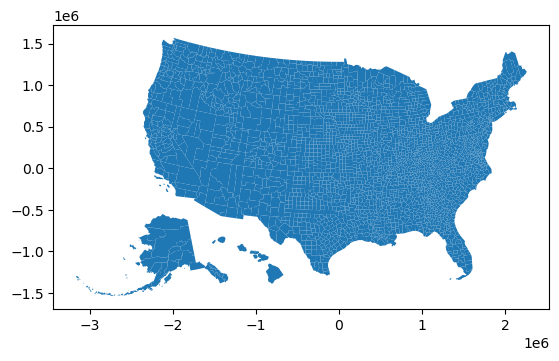

In [1]:
# generate plot by county
from pygris import counties
from pygris.utils import shift_geometry

analysis_year = 2017
us_counties = counties(year = analysis_year)
us_counties = shift_geometry(us_counties)
state_fips_to_drop = ['72', '78', '66', '69', '60']
us_counties = us_counties.loc[~us_counties['STATEFP'].isin(state_fips_to_drop)]
us_counties.plot()

In [2]:
# additional packages

import numpy as np
from pandas import read_csv
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import visualkit_delta as vkd
import warnings
warnings.filterwarnings('ignore')

os.chdir('C:\SynthFirm')

In [3]:
# define scenario
scenario_name = 'national'
analysis_years = ['2019', '2020', '2023']
input_dir = 'inputs_' + scenario_name
plot_dir = 'plots_pandemic'

lehd_file = 'US_naics.csv'
map_file = scenario_name + '_freight.geojson'

us_ton_to_ton = 0.907185
miles_to_km = 1.60934

CFS_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail and IMX', 
                      'Air':'Air and Parcel', 
                      'Parcel':'Air and Parcel'}

FAF_mode_lookup = {1: 'Truck', 2: 'Rail and IMX', 3: 'Other', 4: 'Air and Parcel', 
               5: 'Air and Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

commodity_label = {'bulk': 'Bulk', 'fuel_fert': 'Fuel, fertilizer and chemicals',
                  'interm_food': 'Food and interim product', 'mfr_goods': 'Manufactured goods',
                  'other':'Other', 'total': 'Total'}

list_of_modes = ['Truck', 'Rail and IMX', 'Air and Parcel']
list_of_commodity = ['bulk', 'fuel_fert', 'interm_food', 'mfr_goods', 'total']

In [4]:
# load processed input
plot_pairs = {'Production change (2020-2019)': ('disruption_prod_','base_prod_'),
             'Production change (2023-2020)': ('recovery_prod_', 'disruption_prod_'),
             'Production change (2023-2019)': ('recovery_prod_',  'base_prod_'),
             'Consumption change (2020-2019)': ('disruption_cons_', 'base_cons_'),
             'Consumption change (2023-2020)': ('recovery_cons_', 'disruption_cons_'),
             'Consumption change (2023-2019)': ('recovery_cons_', 'base_cons_')}

output_prefix = {'Production change (2020-2019)': 'prod_delta_2020_2019_',
             'Production change (2023-2020)': 'prod_delta_2023_2020_',
             'Production change (2023-2019)': 'prod_delta_2023_2019_',
             'Consumption change (2020-2019)': 'cons_delta_2020_2019_',
             'Consumption change (2023-2020)': 'cons_delta_2023_2020_',
             'Consumption change (2023-2019)':'cons_delta_2023_2019_'}

unit = '1000 tons/$km^{2}$'

commodity_change_comparison_sctg = read_csv(os.path.join('synthfirm_summary_by_sctg_county.csv'))
commodity_change_comparison_mode = read_csv(os.path.join('synthfirm_summary_by_mode_county.csv'))

#print(commodity_change_comparison_mode.columns)

In [5]:
# convert back to load 
output_columns_sctg = [] 
output_columns_mode = []
for plot_pair in plot_pairs.keys():
    output_attr = plot_pair

    for comm in list_of_commodity:
        delta_attr = output_attr + '-' +  comm
        output_columns_sctg.append(delta_attr)
    for mode in list_of_modes:
        delta_attr = output_attr + '-' +  mode
        output_columns_mode.append(delta_attr)
print(output_columns_mode)

commodity_change_comparison_sctg.loc[:, output_columns_sctg] = \
commodity_change_comparison_sctg.loc[:, output_columns_sctg].multiply(commodity_change_comparison_sctg['area'], axis=0)

commodity_change_comparison_mode.loc[:, output_columns_mode] = \
commodity_change_comparison_mode.loc[:, output_columns_mode].multiply(commodity_change_comparison_mode['area'], axis=0)

['Production change (2020-2019)-Truck', 'Production change (2020-2019)-Rail and IMX', 'Production change (2020-2019)-Air and Parcel', 'Production change (2023-2020)-Truck', 'Production change (2023-2020)-Rail and IMX', 'Production change (2023-2020)-Air and Parcel', 'Production change (2023-2019)-Truck', 'Production change (2023-2019)-Rail and IMX', 'Production change (2023-2019)-Air and Parcel', 'Consumption change (2020-2019)-Truck', 'Consumption change (2020-2019)-Rail and IMX', 'Consumption change (2020-2019)-Air and Parcel', 'Consumption change (2023-2020)-Truck', 'Consumption change (2023-2020)-Rail and IMX', 'Consumption change (2023-2020)-Air and Parcel', 'Consumption change (2023-2019)-Truck', 'Consumption change (2023-2019)-Rail and IMX', 'Consumption change (2023-2019)-Air and Parcel']


In [6]:
# convert wide to long 

commodity_change_by_sctg_long = pd.melt(commodity_change_comparison_sctg,
                                       id_vars=['GEOID',  'FAFID', 'FAFNAME'], 
                                        value_vars=output_columns_sctg, 
                                        var_name='Scenario', value_name='Delta load').reset_index()

commodity_change_by_mode_long = pd.melt(commodity_change_comparison_mode,
                                       id_vars=['GEOID',  'FAFID', 'FAFNAME'], 
                                        value_vars=output_columns_mode, 
                                        var_name='Scenario', value_name='Delta load').reset_index()
commodity_change_by_mode_long.head(5)


,index,GEOID,FAFID,FAFNAME,Scenario,Delta load
0,0,31039,319.0,Rest of NE,Production change (2020-2019)-Truck,-829.044246
1,1,53069,539.0,Rest of WA,Production change (2020-2019)-Truck,1606.700952
2,2,35011,350.0,New Mexico,Production change (2020-2019)-Truck,-47.863905
3,3,31109,319.0,Rest of NE,Production change (2020-2019)-Truck,409.629199
4,4,31129,319.0,Rest of NE,Production change (2020-2019)-Truck,-376.158196


In [7]:
# get baseline attr
output_base_sctg = ['GEOID', 'area'] 
output_base_mode = ['GEOID', 'area']

base_comm_lookup = {}
base_mode_lookup = {}
for dirc in ['prod', 'cons']:
    for comm in list_of_commodity:
        base_attr = f'base_{dirc}_{comm}_per_area'
        output_base_sctg.append(base_attr)
        commodity_change_comparison_sctg[base_attr] *= commodity_change_comparison_sctg['area']
        base_comm_lookup[base_attr] = comm
    for mode in list_of_modes:
        base_attr = f'base_{dirc}_{mode}_per_area'
        output_base_mode.append(base_attr)
        commodity_change_comparison_mode[base_attr] *= commodity_change_comparison_mode['area']
        base_mode_lookup[base_attr] = mode
print(output_base_mode)

base_comm_by_sctg = commodity_change_comparison_sctg[output_base_sctg]
base_comm_by_mode = commodity_change_comparison_mode[output_base_mode]

base_comm_by_mode.head(5)

['GEOID', 'area', 'base_prod_Truck_per_area', 'base_prod_Rail and IMX_per_area', 'base_prod_Air and Parcel_per_area', 'base_cons_Truck_per_area', 'base_cons_Rail and IMX_per_area', 'base_cons_Air and Parcel_per_area']


,GEOID,area,base_prod_Truck_per_area,base_prod_Rail and IMX_per_area,base_prod_Air and Parcel_per_area,base_cons_Truck_per_area,base_cons_Rail and IMX_per_area,base_cons_Air and Parcel_per_area
0,31039,1488.343176,2411.569668,250.276233,0.592297,3246.920485,62.146469,8.292746
1,53069,742.545193,48.013121,0.247934,2.115577,416.570705,31.405377,0.554146
2,35011,6045.908993,51.305233,1.421355,0.006742,33.539455,0.627578,0.224939
3,31109,2192.120047,4176.080701,347.099834,54.342998,20343.766960,1898.164042,192.621175
4,31129,1491.363670,494.636622,12.864703,0.155904,419.239149,26.551375,2.295985


In [8]:
# convert base from wide to long
output_base_sctg.remove('GEOID')
output_base_sctg.remove('area')
output_base_mode.remove('GEOID')
output_base_mode.remove('area')

direction_mapping = {'prod': 'Production', 'cons': 'Consumption'}
base_by_sctg_long = pd.melt(base_comm_by_sctg,
                                       id_vars=['GEOID'], 
                                        value_vars=output_base_sctg, 
                                        var_name='Scenario', value_name='Base load').reset_index()
base_by_sctg_long.loc[:, 'Direction'] = \
base_by_sctg_long.loc[:, 'Scenario'].str.split('_').str[1]
base_by_sctg_long.loc[:, 'Direction'] = base_by_sctg_long.loc[:, 'Direction'].map(direction_mapping)

base_by_sctg_long.loc[:, 'SCTG_Name'] = \
base_by_sctg_long.loc[:, 'Scenario'].map(base_comm_lookup)
base_by_sctg_long.loc[:, 'Commodity'] = base_by_sctg_long.loc[:, 'SCTG_Name'].map(commodity_label)

base_by_mode_long = pd.melt(base_comm_by_mode,
                                       id_vars=['GEOID'], 
                                        value_vars=output_base_mode, 
                                        var_name='Scenario', value_name='Base load').reset_index()
base_by_mode_long.loc[:, 'Mode'] = \
base_by_mode_long.loc[:, 'Scenario'].map(base_mode_lookup)

base_by_mode_long.loc[:, 'Direction'] = \
base_by_mode_long.loc[:, 'Scenario'].str.split('_').str[1]
base_by_mode_long.loc[:, 'Direction'] = base_by_mode_long.loc[:, 'Direction'].map(direction_mapping)
base_by_mode_long.head(5)

,index,GEOID,Scenario,Base load,Mode,Direction
0,0,31039,base_prod_Truck_per_area,2411.569668,Truck,Production
1,1,53069,base_prod_Truck_per_area,48.013121,Truck,Production
2,2,35011,base_prod_Truck_per_area,51.305233,Truck,Production
3,3,31109,base_prod_Truck_per_area,4176.080701,Truck,Production
4,4,31129,base_prod_Truck_per_area,494.636622,Truck,Production


In [9]:
base_by_sctg_long = base_by_sctg_long.sort_values(['Commodity', 'Base load'], ascending=[True, False])
def top_90_percentile(group):
    threshold = group['Base load'].quantile(0.9)
    return group[group['Base load'] >= threshold]

print(len(base_by_sctg_long))
base_by_sctg_long['threshold'] = 0.9 * base_by_sctg_long.groupby('Commodity')['Base load'].transform('sum')
base_by_sctg_long['cumsum'] = base_by_sctg_long.groupby('Commodity')['Base load'].transform('cumsum')
base_by_sctg_long.head(5)
base_by_sctg_long_filtered = base_by_sctg_long.loc[base_by_sctg_long['cumsum'] <= base_by_sctg_long['threshold']]
print(len(base_by_sctg_long_filtered))

base_by_sctg_long_filtered = base_by_sctg_long_filtered[['GEOID', 'Base load', 'Commodity', 'Direction']]
print(base_by_sctg_long.Commodity.unique())
base_by_sctg_long_filtered.head(5)

31420
10688
['Bulk' 'Food and interim product' 'Fuel, fertilizer and chemicals'
 'Manufactured goods' 'Total']


,GEOID,Base load,Commodity,Direction
1400,56005,51573.973147,Bulk,Production
16981,48201,45478.056518,Bulk,Consumption
1930,12105,44801.856336,Bulk,Production
16095,6037,39073.705415,Bulk,Consumption
2405,48307,37289.783930,Bulk,Production


In [10]:
base_by_mode_long = base_by_mode_long.sort_values(['Mode', 'Base load'], ascending=[True, False])


print(len(base_by_sctg_long))
base_by_mode_long['threshold'] = 0.9 * base_by_mode_long.groupby('Mode')['Base load'].transform('sum')
base_by_mode_long['cumsum'] = base_by_mode_long.groupby('Mode')['Base load'].transform('cumsum')
base_by_mode_long.head(5)
base_by_mode_long_filtered = base_by_mode_long.loc[base_by_mode_long['cumsum'] <= base_by_mode_long['threshold']]
print(len(base_by_mode_long_filtered))

base_by_mode_long_filtered = base_by_mode_long_filtered[['GEOID', 'Base load', 'Mode', 'Direction']]
print(base_by_mode_long_filtered.Mode.unique())
base_by_mode_long_filtered.head(5)

31420
6020
['Air and Parcel' 'Rail and IMX' 'Truck']


,GEOID,Base load,Mode,Direction
18847,15003,7607.302100,Air and Parcel,Consumption
9421,15003,7081.589769,Air and Parcel,Production
18851,15001,4094.424629,Air and Parcel,Consumption
18850,15009,3496.383404,Air and Parcel,Consumption
18822,2020,3369.275874,Air and Parcel,Consumption


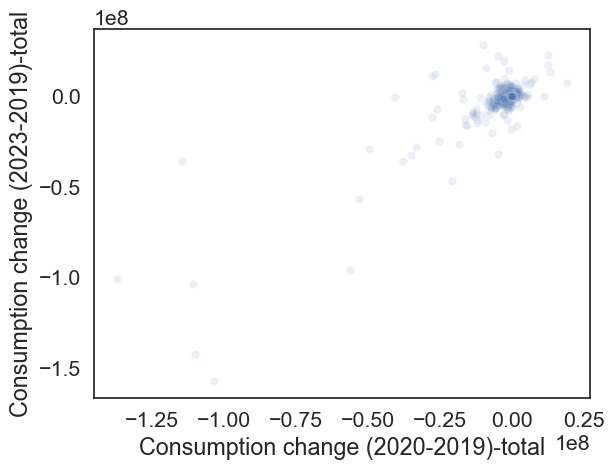

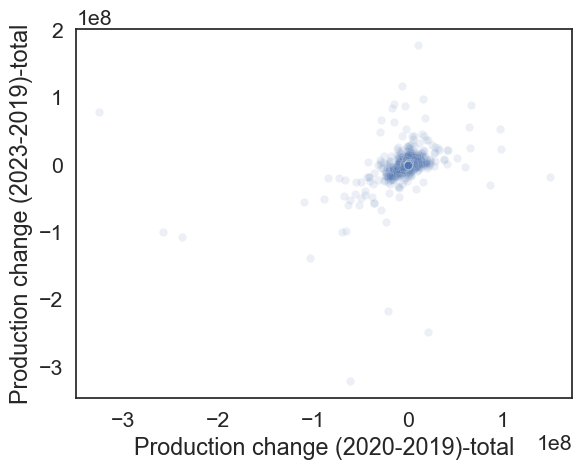

In [90]:
# commodity_change_comparison_sctg_check = commodity_change_comparison_sctg.copy()
# commodity_change_comparison_sctg_check.loc[:, output_columns_sctg] = \
# commodity_change_comparison_sctg_check.loc[:, output_columns_sctg].multiply(commodity_change_comparison_sctg_check['area'], axis=0)


# # test pair plot
# sns.scatterplot(data=commodity_change_comparison_sctg_check, 
#                 x="Consumption change (2020-2019)-total", 
#                 y="Consumption change (2023-2019)-total", alpha = 0.1)
# plt.show()

# sns.scatterplot(data=commodity_change_comparison_sctg_check, 
#                 x="Production change (2020-2019)-total", 
#                 y="Production change (2023-2019)-total", alpha = 0.1)
# plt.show()


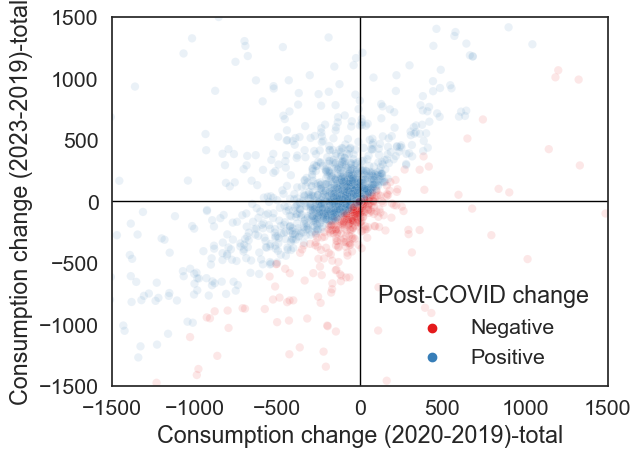

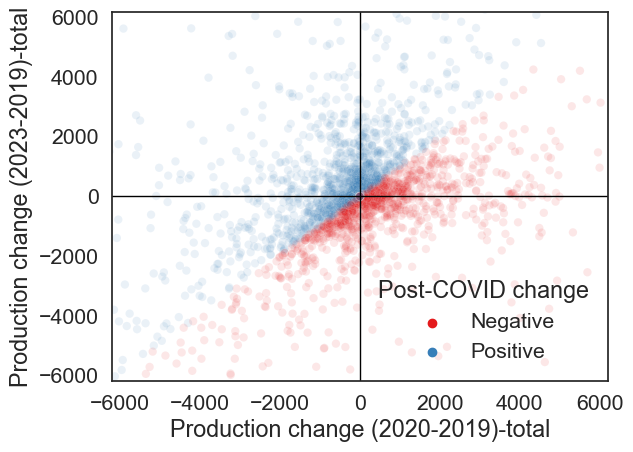

In [48]:
# commodity_change_comparison_sctg_check.loc[:, 'Post-COVID change'] = 'Positive'
# commodity_change_comparison_sctg_check.loc[commodity_change_comparison_sctg_check['Consumption change (2023-2020)-total']<=0,
#                                            'Post-COVID change'] = 'Negative'
# upper_bound = max(commodity_change_comparison_sctg_check['Consumption change (2020-2019)-total'].quantile(0.975),
#                   commodity_change_comparison_sctg_check['Consumption change (2023-2019)-total'].quantile(0.975))
# lower_bound = min(commodity_change_comparison_sctg_check['Consumption change (2020-2019)-total'].quantile(0.025),
#                   commodity_change_comparison_sctg_check['Consumption change (2023-2019)-total'].quantile(0.025))
# upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
# lower_bound = -upper_bound
# ax = sns.scatterplot(data=commodity_change_comparison_sctg_check, 
#                 x="Consumption change (2020-2019)-total", 
#                 y="Consumption change (2023-2019)-total", alpha = 0.1, hue='Post-COVID change',
#                     palette = 'Set1')
# ax.axhline(0, color='black', linewidth=1)
# ax.axvline(0, color='black', linewidth=1)
# plt.xlim([lower_bound, upper_bound])
# plt.ylim([lower_bound, upper_bound])
# plt.show()

# commodity_change_comparison_sctg_check.loc[:, 'Post-COVID change'] = 'Positive'
# commodity_change_comparison_sctg_check.loc[commodity_change_comparison_sctg_check['Production change (2023-2020)-total']<=0,
#                                            'Post-COVID change'] = 'Negative'
# upper_bound = max(commodity_change_comparison_sctg_check['Production change (2020-2019)-total'].quantile(0.975),
#                   commodity_change_comparison_sctg_check['Production change (2023-2019)-total'].quantile(0.975))
# lower_bound = min(commodity_change_comparison_sctg_check['Production change (2020-2019)-total'].quantile(0.025),
#                   commodity_change_comparison_sctg_check['Production change (2023-2019)-total'].quantile(0.025))
# upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
# lower_bound = -upper_bound
# ax = sns.scatterplot(data=commodity_change_comparison_sctg_check, 
#                 x="Production change (2020-2019)-total", 
#                 y="Production change (2023-2019)-total", alpha = 0.1, hue='Post-COVID change', 
#                      hue_order = ['Negative', 'Positive'], 
#                     palette = 'Set1')
# ax.axhline(0, color='black', linewidth=1)
# ax.axvline(0, color='black', linewidth=1)
# plt.xlim([lower_bound, upper_bound])
# plt.ylim([lower_bound, upper_bound])
# plt.show()

In [40]:
# commodity_change_comparison_sctg_check['Consumption change (2023-2020)-total'].head(5)

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: Consumption change (2023-2020)-total, dtype: object

In [11]:
# format table
commodity_change_by_sctg_long.loc[:, 'Direction'] = \
commodity_change_by_sctg_long.loc[:, 'Scenario'].str.split(' ').str[0]

commodity_change_by_sctg_long.loc[:, 'SCTG_Name'] = \
commodity_change_by_sctg_long.loc[:, 'Scenario'].str.split('-').str[2]
commodity_change_by_sctg_long.loc[:, 'Commodity'] = commodity_change_by_sctg_long.loc[:, 'SCTG_Name'].map(commodity_label)

commodity_change_by_sctg_long.loc[:, 'Period'] = commodity_change_by_sctg_long.loc[:, 'Scenario'].str.split(' ').str[2]

commodity_change_by_sctg_long.loc[:, 'Period'] = commodity_change_by_sctg_long.loc[:, 'Period'].str.extract(r'\((.*?)\)')[0]
commodity_change_by_sctg_long.loc[:, 'Sign'] = '+'
commodity_change_by_sctg_long.loc[commodity_change_by_sctg_long['Delta load']<0, 'Sign'] = '-'
# c=c.str.extract(r'\((.*?)\)')
# commodity_change_by_sctg_wide.loc[:, 'Period'] = c[0]

commodity_change_by_sctg_long.head(5)

,index,GEOID,FAFID,FAFNAME,Scenario,Delta load,Direction,SCTG_Name,Commodity,Period,Sign
0,0,31039,319.0,Rest of NE,Production change (2020-2019)-bulk,-419.892325,Production,bulk,Bulk,2020-2019,-
1,1,53069,539.0,Rest of WA,Production change (2020-2019)-bulk,1685.693723,Production,bulk,Bulk,2020-2019,+
2,2,35011,350.0,New Mexico,Production change (2020-2019)-bulk,-50.674608,Production,bulk,Bulk,2020-2019,-
3,3,31109,319.0,Rest of NE,Production change (2020-2019)-bulk,-6.128327,Production,bulk,Bulk,2020-2019,-
4,4,31129,319.0,Rest of NE,Production change (2020-2019)-bulk,-137.609409,Production,bulk,Bulk,2020-2019,-


In [12]:
# filter and adjust data

#base_by_sctg_long_filtered = base_by_sctg_long_filtered[['GEOID', 'Base load', 'Commodity', 'Direction']]
print(len(commodity_change_by_sctg_long))
print(base_by_sctg_long_filtered.Commodity.unique())
print(commodity_change_by_sctg_long.Commodity.unique())
commodity_change_by_sctg_long_filtered = pd.merge(commodity_change_by_sctg_long,
                                                 base_by_sctg_long_filtered, 
                                                  on = ['GEOID', 'Commodity', 'Direction'], how = 'inner')
print(len(commodity_change_by_sctg_long_filtered))

def clip_outliers_iqr(group, col='Delta load'):
    Q1 = group[col].quantile(0.25)
    Q3 = group[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    group[col] = group[col].clip(lower, upper)
    return group

commodity_change_by_sctg_long_adjusted = \
commodity_change_by_sctg_long_filtered.groupby('Scenario', group_keys=False).apply(clip_outliers_iqr)
print(len(commodity_change_by_sctg_long_adjusted))
commodity_change_by_sctg_long_adjusted.head(5)

94260
['Bulk' 'Food and interim product' 'Fuel, fertilizer and chemicals'
 'Manufactured goods' 'Total']
['Bulk' 'Fuel, fertilizer and chemicals' 'Food and interim product'
 'Manufactured goods' 'Total']
32064
32064


,index,GEOID,FAFID,FAFNAME,Scenario,Delta load,Direction,SCTG_Name,Commodity,Period,Sign,Base load
0,9,39063,399.0,Rest of OH,Production change (2020-2019)-bulk,3923.232956,Production,bulk,Bulk,2020-2019,+,1559.206556
1,15719,39063,399.0,Rest of OH,Production change (2023-2020)-bulk,-3682.999798,Production,bulk,Bulk,2023-2020,-,1559.206556
2,31429,39063,399.0,Rest of OH,Production change (2023-2019)-bulk,351.516376,Production,bulk,Bulk,2023-2019,+,1559.206556
3,15,55111,559.0,Rest of WI,Production change (2020-2019)-bulk,1054.217454,Production,bulk,Bulk,2020-2019,+,4409.801827
4,15725,55111,559.0,Rest of WI,Production change (2023-2020)-bulk,66.583124,Production,bulk,Bulk,2023-2020,+,4409.801827


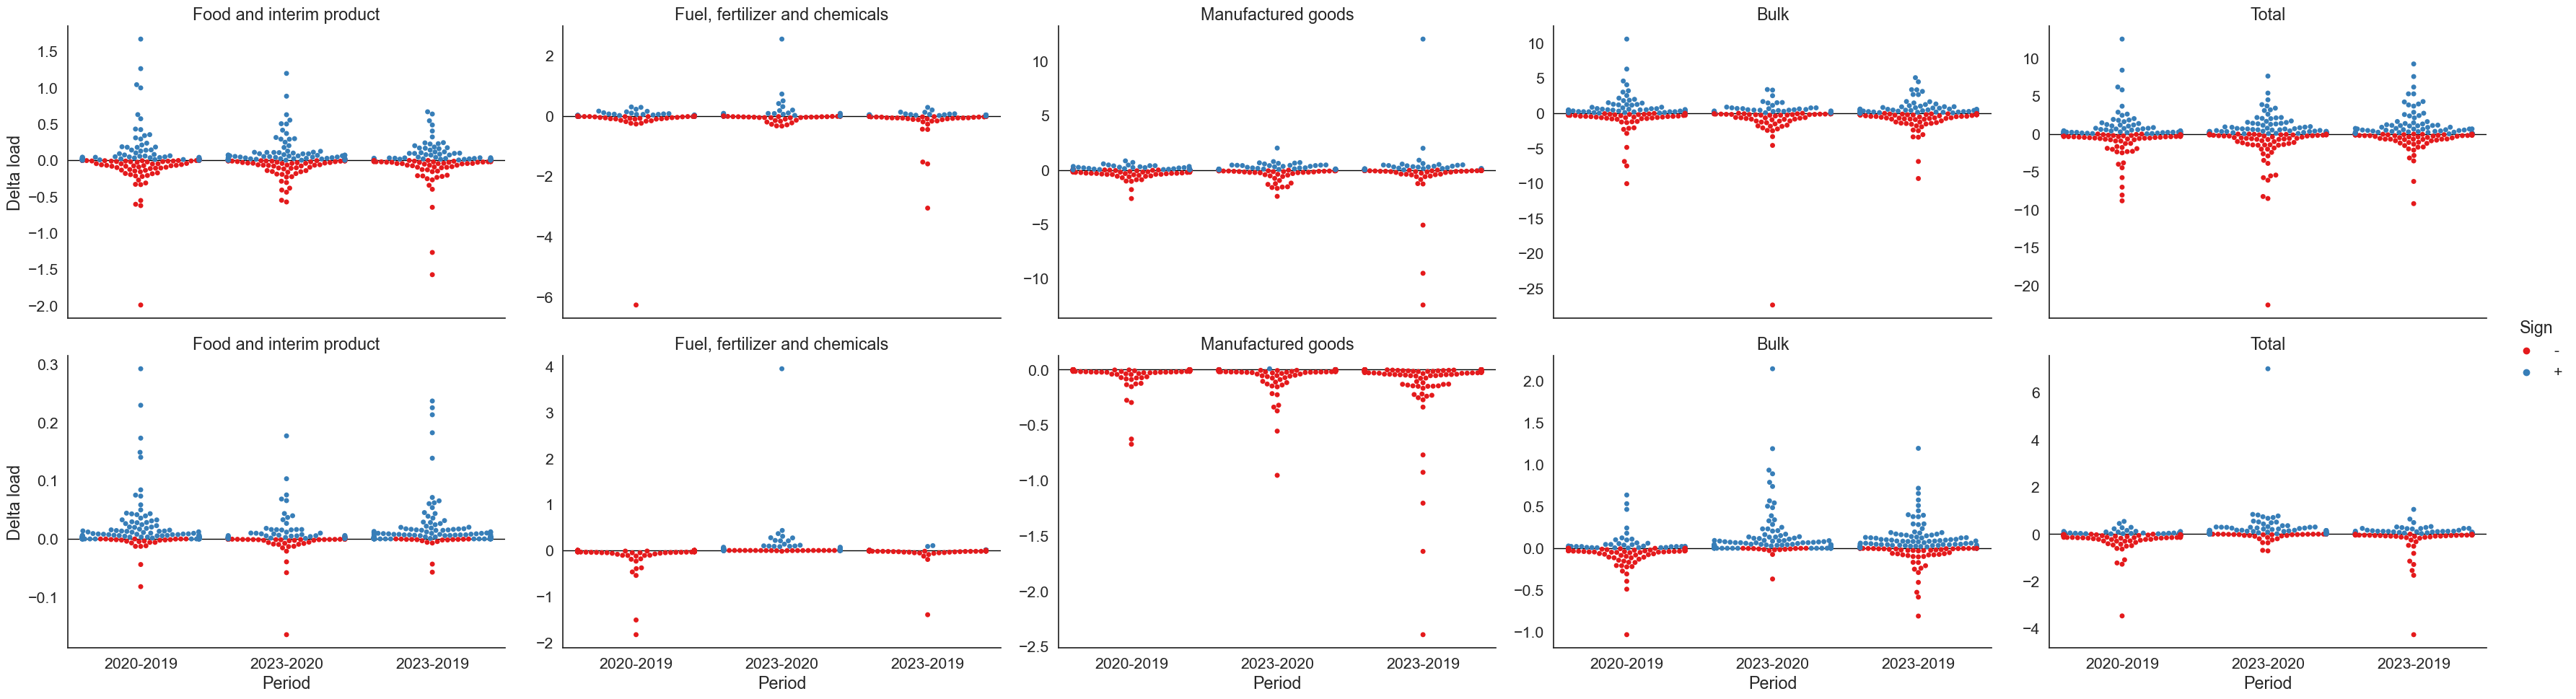

In [18]:
# plot SWARM
# commodity_change_by_sctg_long_sample = commodity_change_by_sctg_long.sample(5000)

# ax = sns.catplot(
#     data=commodity_change_by_sctg_long_sample, kind="swarm", 
#     x="Period", y="Delta load", hue = 'Sign', palette = 'Set1',
#     col="Commodity", row="Direction", sharey = False,
#     order = ['2020-2019', '2023-2020', '2023-2019'], hue_order = ['-', '+'],
#     aspect=1.4
# )

# ax.set_titles("{col_name}")
# for axn in ax.axes.flat:
#     axn.axhline(0, color='black', linewidth=1)
# plt.show()

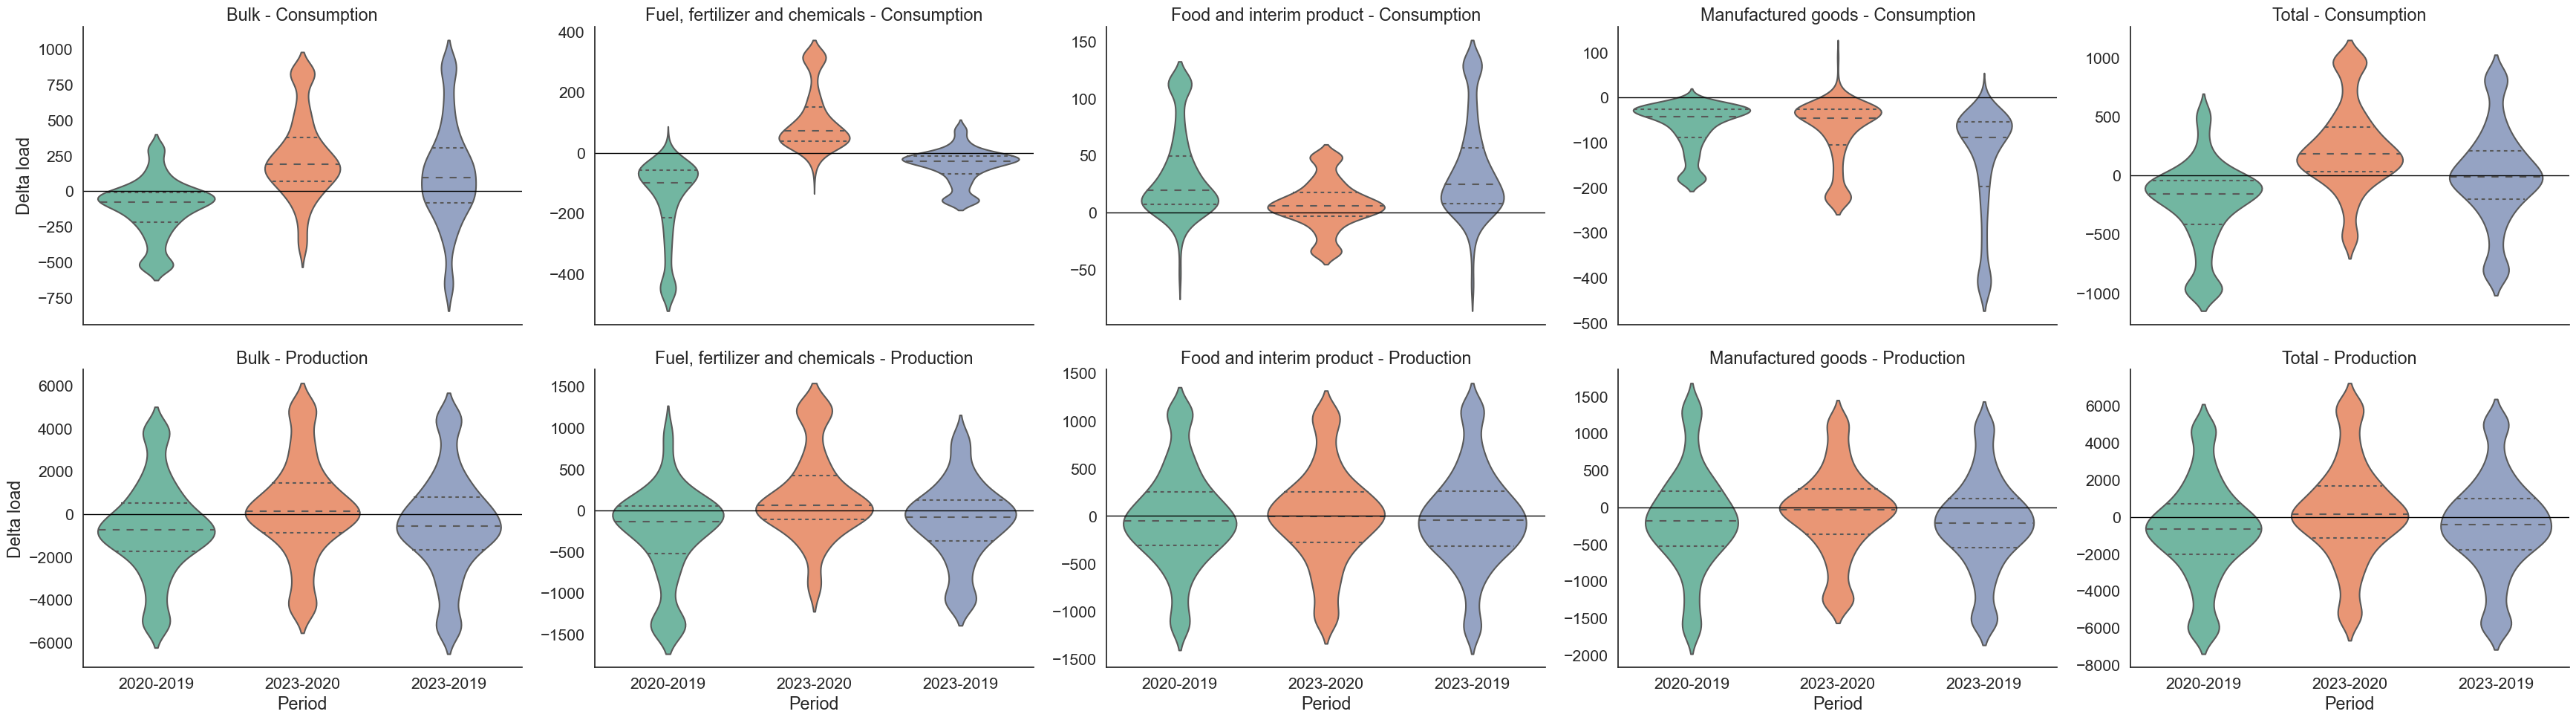

In [13]:
ax = sns.catplot(
    data=commodity_change_by_sctg_long_adjusted, kind="violin", 
    x="Period", y="Delta load", palette = 'Set2',
    col="Commodity", row="Direction", sharey = False,
    order = ['2020-2019', '2023-2020', '2023-2019'], 
    row_order = ['Consumption', 'Production'],
    aspect=1.4, inner = 'quart', fill = False
)

ax.set_titles("{col_name} - {row_name}")
for axn in ax.axes.flat:
    axn.axhline(0, color='black', linewidth=1)
plt.savefig(os.path.join(plot_dir, 'delta_load_by_sctg_violin.png'), dpi = 300)
plt.show()

In [14]:
# format table
commodity_change_by_mode_long.loc[:, 'Direction'] = \
commodity_change_by_mode_long.loc[:, 'Scenario'].str.split(' ').str[0]

commodity_change_by_mode_long.loc[:, 'Mode'] = \
commodity_change_by_mode_long.loc[:, 'Scenario'].str.split('-').str[2]

commodity_change_by_mode_long.loc[:, 'Period'] = commodity_change_by_mode_long.loc[:, 'Scenario'].str.split(' ').str[2]

commodity_change_by_mode_long.loc[:, 'Period'] = commodity_change_by_mode_long.loc[:, 'Period'].str.extract(r'\((.*?)\)')[0]

commodity_change_by_mode_long.head(5)

,index,GEOID,FAFID,FAFNAME,Scenario,Delta load,Direction,Mode,Period
0,0,31039,319.0,Rest of NE,Production change (2020-2019)-Truck,-829.044246,Production,Truck,2020-2019
1,1,53069,539.0,Rest of WA,Production change (2020-2019)-Truck,1606.700952,Production,Truck,2020-2019
2,2,35011,350.0,New Mexico,Production change (2020-2019)-Truck,-47.863905,Production,Truck,2020-2019
3,3,31109,319.0,Rest of NE,Production change (2020-2019)-Truck,409.629199,Production,Truck,2020-2019
4,4,31129,319.0,Rest of NE,Production change (2020-2019)-Truck,-376.158196,Production,Truck,2020-2019


In [15]:
print(len(commodity_change_by_mode_long))
commodity_change_by_mode_long_filtered = pd.merge(commodity_change_by_mode_long,
                                                 base_by_mode_long_filtered,
                                                 on = ['GEOID', 'Mode', 'Direction'],
                                                 how = 'inner')
commodity_change_by_mode_long_adjusted = \
commodity_change_by_mode_long_filtered.groupby('Scenario', group_keys=False).apply(clip_outliers_iqr)
print(len(commodity_change_by_mode_long_adjusted))
commodity_change_by_mode_long_adjusted.head(5)

56556
18060


,index,GEOID,FAFID,FAFNAME,Scenario,Delta load,Direction,Mode,Period,Base load
0,0,31039,319.0,Rest of NE,Production change (2020-2019)-Truck,-829.044246,Production,Truck,2020-2019,2411.569668
1,9426,31039,319.0,Rest of NE,Production change (2023-2020)-Truck,595.584045,Production,Truck,2023-2020,2411.569668
2,18852,31039,319.0,Rest of NE,Production change (2023-2019)-Truck,-233.460200,Production,Truck,2023-2019,2411.569668
3,3,31109,319.0,Rest of NE,Production change (2020-2019)-Truck,409.629199,Production,Truck,2020-2019,4176.080701
4,9429,31109,319.0,Rest of NE,Production change (2023-2020)-Truck,-403.918328,Production,Truck,2023-2020,4176.080701


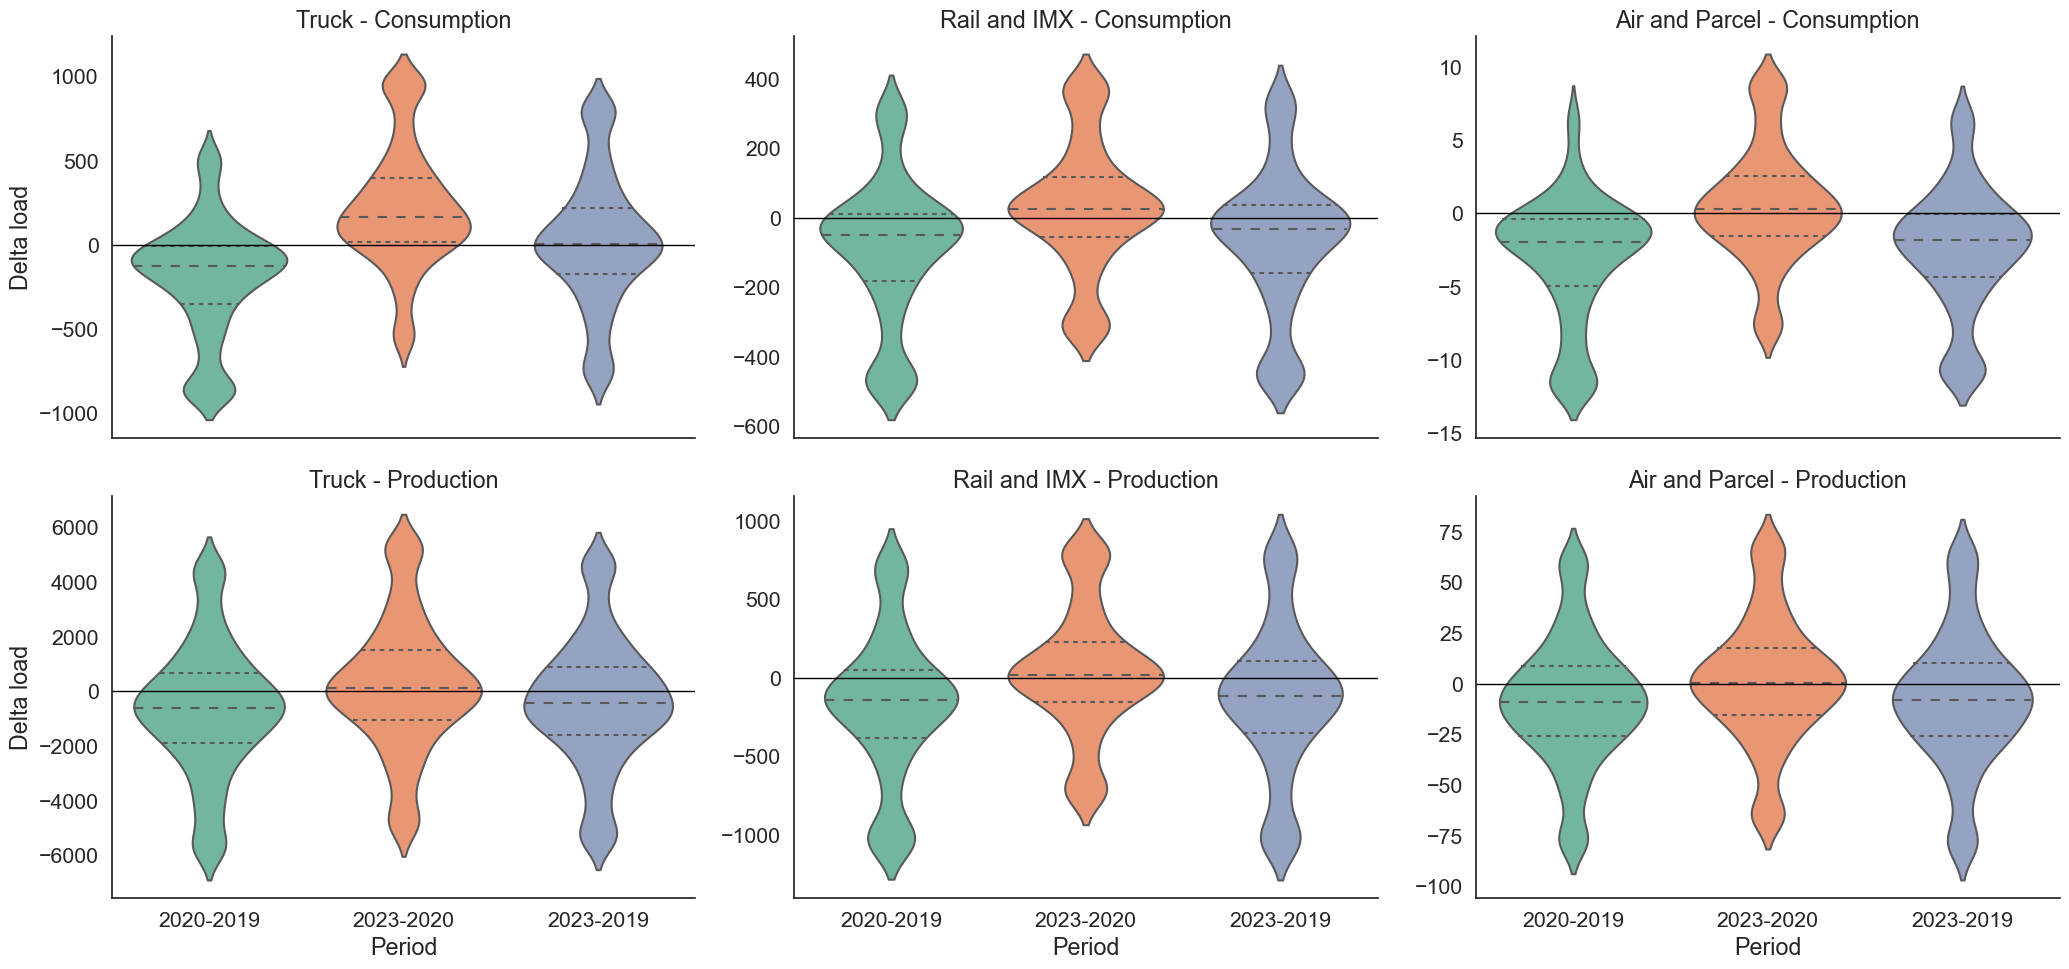

In [16]:
ax = sns.catplot(
    data=commodity_change_by_mode_long_adjusted, kind="violin", 
    x="Period", y="Delta load", palette = 'Set2',
    col="Mode", row="Direction", sharey = False,
    order = ['2020-2019', '2023-2020', '2023-2019'], 
    row_order = ['Consumption', 'Production'],
    aspect=1.4, inner = 'quart', fill = False,
)

ax.set_titles("{col_name} - {row_name}")
for axn in ax.axes.flat:
    axn.axhline(0, color='black', linewidth=1)
#plt.yscale('symlog')
plt.savefig(os.path.join(plot_dir, 'delta_load_by_mode_violin.png'), dpi = 300)
plt.show()

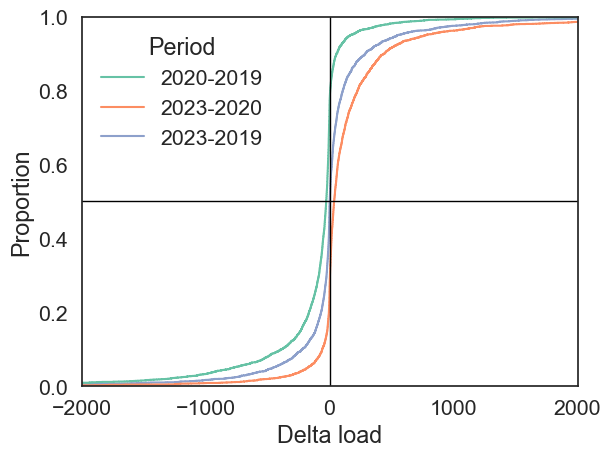

In [72]:
commodity_change_by_mode_plot = \
commodity_change_by_mode_long.loc[(commodity_change_by_mode_long['Direction'] == 'Consumption') &\
                                 ((commodity_change_by_mode_long['Mode'] == 'Truck'))]
ax = sns.ecdfplot(data=commodity_change_by_mode_plot, x="Delta load", hue="Period", palette = 'Set2')
plt.xlim([-2000, 2000])
ax.axhline(0.5, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

In [17]:
# outcome group by SCTG
print(commodity_change_by_sctg_long_adjusted.columns)
ind_col = ['GEOID', 'FAFNAME', 'Direction', 'Commodity']
commodity_outcome_by_sctg = pd.pivot_table(commodity_change_by_sctg_long_adjusted,
                                          index=ind_col, columns='Period', values = 'Delta load', 
                                           aggfunc='sum').reset_index()
commodity_outcome_by_sctg = commodity_outcome_by_sctg.loc[commodity_outcome_by_sctg['Direction'] == 'Consumption']
commodity_outcome_by_sctg.head(5)

Index(['index', 'GEOID', 'FAFID', 'FAFNAME', 'Scenario', 'Delta load',
       'Direction', 'SCTG_Name', 'Commodity', 'Period', 'Sign', 'Base load'],
      dtype='object')


Period,GEOID,FAFNAME,Direction,Commodity,2020-2019,2023-2019,2023-2020
3,1003,Mobile,Consumption,Bulk,-527.665945,-90.663718,612.055997
4,1003,Mobile,Consumption,Food and interim product,38.373013,22.847249,-15.525764
5,1003,Mobile,Consumption,"Fuel, fertilizer and chemicals",-162.784322,-92.396679,70.387643
6,1003,Mobile,Consumption,Manufactured goods,-71.857586,-130.641407,-58.783821
7,1003,Mobile,Consumption,Total,-882.303351,-202.991799,679.311552


In [67]:
conditions = [
    (commodity_outcome_by_sctg['2020-2019'] <= 0) & (commodity_outcome_by_sctg['2023-2019'] >= 0),
    (commodity_outcome_by_sctg['2020-2019'] <= 0) & (commodity_outcome_by_sctg['2023-2019'] < 0) & (commodity_outcome_by_sctg['2023-2020'] < 0),
    (commodity_outcome_by_sctg['2020-2019'] <= 0) & (commodity_outcome_by_sctg['2023-2019'] < 0) & (commodity_outcome_by_sctg['2023-2020'] >= 0),
    (commodity_outcome_by_sctg['2020-2019'] >= 0) & (commodity_outcome_by_sctg['2023-2019'] > 0),
    (commodity_outcome_by_sctg['2020-2019'] >= 0) & (commodity_outcome_by_sctg['2023-2019'] <= 0)
]
choices = ['2-Rebound', '4-Decline', '3-Recover', '1-Growth', '5-Lagged decline']

commodity_outcome_by_sctg['Outcome'] = np.select(conditions, choices, default='Other')

print(commodity_outcome_by_sctg.groupby('Outcome').size())

Outcome
1-Growth            1385
2-Rebound           1198
3-Recover           1456
4-Decline           1375
5-Lagged decline     182
dtype: int64


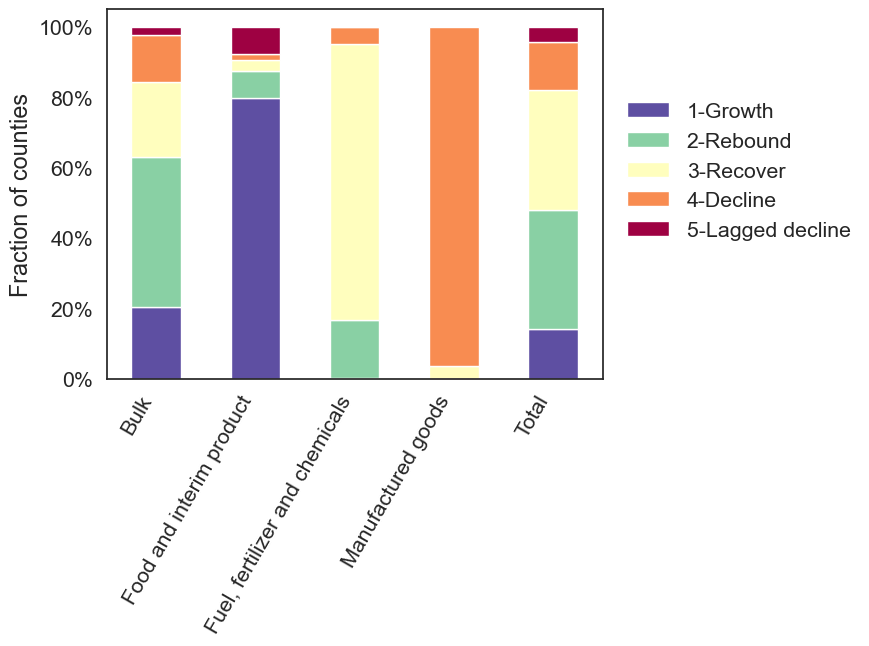

Outcome                         1-Growth  2-Rebound  3-Recover  4-Decline  \
Commodity                                                                   
Bulk                            0.202803   0.426216   0.213520   0.132729   
Food and interim product        0.797138   0.075758   0.031145   0.019360   
Fuel, fertilizer and chemicals  0.002347   0.164319   0.784038   0.048122   
Manufactured goods              0.000000   0.000000   0.034826   0.965174   
Total                           0.142003   0.337070   0.341555   0.134529   

Outcome                         5-Lagged decline  
Commodity                                         
Bulk                                    0.024732  
Food and interim product                0.076599  
Fuel, fertilizer and chemicals          0.001174  
Manufactured goods                      0.000000  
Total                                   0.044843  


In [68]:
from matplotlib.ticker import PercentFormatter
outcome_by_sctg = pd.pivot_table(commodity_outcome_by_sctg, index = 'Commodity', columns='Outcome', values = 'GEOID', 
                                           aggfunc='count')
outcome_by_sctg_normalized = outcome_by_sctg.div(outcome_by_sctg.sum(axis=1), axis=0)
outcome_by_sctg_normalized.fillna(0, inplace = True)
col_order = ['1-Growth', '2-Rebound', '3-Recover', '4-Decline', '5-Lagged decline']
outcome_by_sctg_normalized = outcome_by_sctg_normalized[col_order]
ax = outcome_by_sctg_normalized.plot(kind = 'bar', stacked = True, cmap = 'Spectral_r')
plt.xticks(rotation = 60, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Fraction of counties')
plt.xlabel('')
ax.yaxis.set_major_formatter(PercentFormatter(1.0)) 
plt.savefig(os.path.join(plot_dir, 'outcome_frac_by_sctg.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()
print(outcome_by_sctg_normalized)

In [59]:
# outcome group by mode
print(commodity_change_by_mode_long_adjusted.columns)
ind_col = ['GEOID', 'FAFNAME', 'Direction', 'Mode']
commodity_outcome_by_mode = pd.pivot_table(commodity_change_by_mode_long_adjusted,
                                          index=ind_col, columns='Period', values = 'Delta load', 
                                           aggfunc='sum').reset_index()
commodity_outcome_by_mode = commodity_outcome_by_mode.loc[commodity_outcome_by_mode['Direction'] == 'Consumption']
commodity_outcome_by_mode.head(5)

Index(['index', 'GEOID', 'FAFID', 'FAFNAME', 'Scenario', 'Delta load',
       'Direction', 'Mode', 'Period', 'Base load'],
      dtype='object')


Period,GEOID,FAFNAME,Direction,Mode,2020-2019,2023-2019,2023-2020
1,1003,Mobile,Consumption,Air and Parcel,0.084892,-1.626058,-1.710950
2,1003,Mobile,Consumption,Rail and IMX,-474.520887,-153.426987,375.413642
3,1003,Mobile,Consumption,Truck,-220.628156,-47.938753,172.689403
8,1011,Rest of AL,Consumption,Rail and IMX,-16.190545,331.925184,375.413642
11,1015,Rest of AL,Consumption,Air and Parcel,-11.788556,-10.580512,6.910832


In [60]:
conditions = [
    (commodity_outcome_by_mode['2020-2019'] <= 0) & (commodity_outcome_by_mode['2023-2019'] >= 0),
    (commodity_outcome_by_mode['2020-2019'] <= 0) & (commodity_outcome_by_mode['2023-2019'] < 0) & (commodity_outcome_by_mode['2023-2020'] < 0),
    (commodity_outcome_by_mode['2020-2019'] <= 0) & (commodity_outcome_by_mode['2023-2019'] < 0) & (commodity_outcome_by_mode['2023-2020'] >= 0),
    (commodity_outcome_by_mode['2020-2019'] >= 0) & (commodity_outcome_by_mode['2023-2019'] > 0),
    (commodity_outcome_by_mode['2020-2019'] >= 0) & (commodity_outcome_by_mode['2023-2019'] <= 0)
]
choices = ['2-Rebound', '4-Decline', '3-Recover', '1-Growth', '5-Lagged decline']

commodity_outcome_by_mode['Outcome'] = np.select(conditions, choices, default='Other')

print(commodity_outcome_by_mode.groupby('Outcome').size())

Outcome
1-Growth            471
2-Rebound           733
3-Recover           944
4-Decline           597
5-Lagged decline    255
dtype: int64


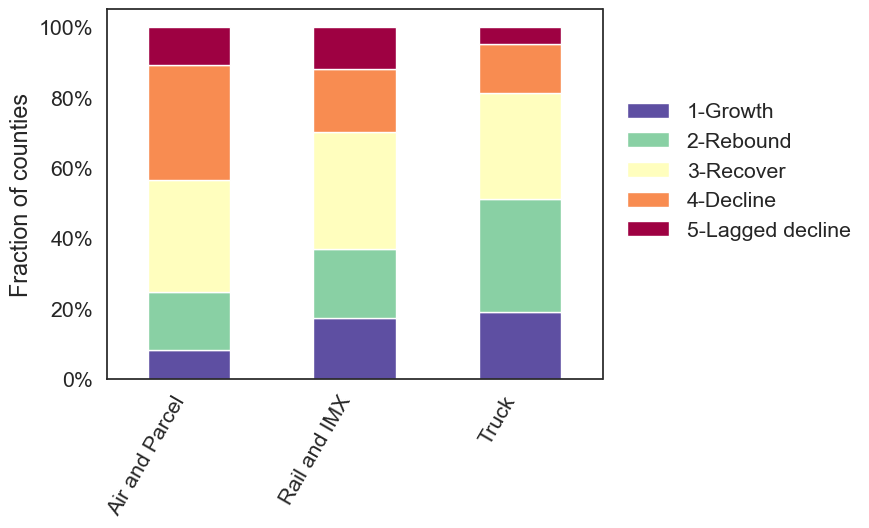

Outcome         1-Growth  2-Rebound  3-Recover  4-Decline  5-Lagged decline
Mode                                                                       
Air and Parcel  0.081395   0.166667   0.316537   0.326873          0.108527
Rail and IMX    0.172067   0.196648   0.334078   0.178771          0.118436
Truck           0.190834   0.321563   0.300526   0.138242          0.048835


In [61]:
outcome_by_mode = pd.pivot_table(commodity_outcome_by_mode, index = 'Mode', columns='Outcome', values = 'GEOID', 
                                           aggfunc='count')
outcome_by_mode_normalized = outcome_by_mode.div(outcome_by_mode.sum(axis=1), axis=0)
outcome_by_mode_normalized.fillna(0, inplace = True)
col_order = ['1-Growth', '2-Rebound', '3-Recover', '4-Decline', '5-Lagged decline']
outcome_by_mode_normalized = outcome_by_mode_normalized[col_order]
ax = outcome_by_mode_normalized.plot(kind = 'bar', stacked = True, cmap = 'Spectral_r')
plt.xticks(rotation = 60, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Fraction of counties')
plt.xlabel('')
ax.yaxis.set_major_formatter(PercentFormatter(1.0)) 
plt.savefig(os.path.join(plot_dir, 'outcome_frac_by_mode.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()
print(outcome_by_mode_normalized)

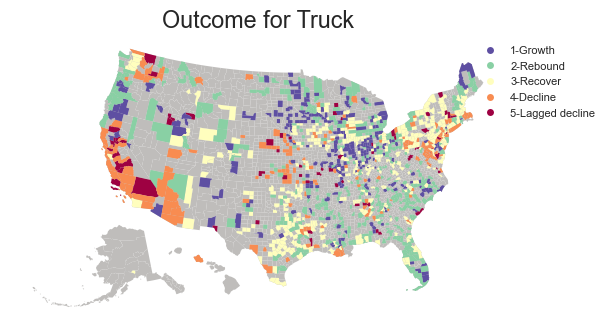

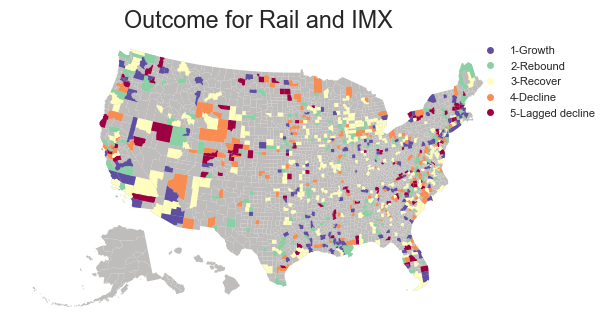

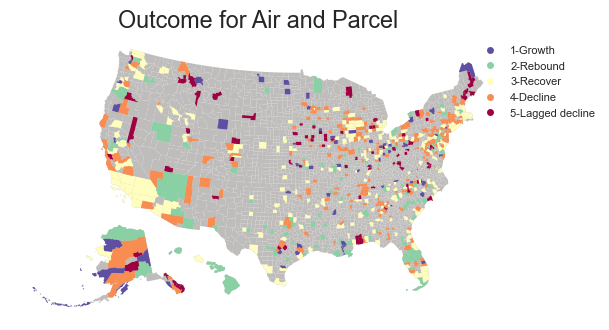

In [66]:
# plot map by mode
outcome_by_mode_zone = pd.pivot(commodity_outcome_by_mode, index = 'GEOID', columns='Mode', values = 'Outcome').reset_index()


outcome_by_mode_zone.loc[:, 'GEOID'] = outcome_by_mode_zone.loc[:, 'GEOID'].astype(int).astype(str).str.zfill(5)
us_counties.loc[:, 'GEOID'] = us_counties.loc[:, 'GEOID'].astype(int).astype(str).str.zfill(5)
us_counties_with_mode = us_counties.merge(outcome_by_mode_zone, on = 'GEOID', how = 'inner')

# Ensure the order of colors matches the order of categories in your data
color_list = [custom_colors.get(c, '#bfbdbb') for c in col_order] # Default to black if category not in custom_colors

# Create a ListedColormap
custom_cmap = ListedColormap(color_list)
for mode in list_of_modes:
    ax = us_counties.plot(facecolor='#bfbdbb', linewidth = 0.01)
    us_counties_with_to_plot = us_counties_with_mode.dropna(subset = [mode])
    us_counties_with_to_plot.plot(
            figsize=(6, 4.5),
            ax = ax,
            column=mode, 
            legend=True,
            cmap = 'Spectral_r',
#             color=us_counties_with_to_plot['color'],
            linewidth=0.01, categorical = True,
            legend_kwds={'bbox_to_anchor': (1.2, 1), 'markerscale': 0.5, 'fontsize':8},
            edgecolor='none')
#     leg = ax.get_legend()
#     leg.set_bbox_to_anchor((1.15, 1))  # (x, y) -- adjust x for distance from plot
#     for text in leg.get_texts():
#         text.set_fontsize(8)  # Smaller label font
    ax.grid(False)
    ax.axis('off')
    plt.title(f'Outcome for {mode}')
    filename = os.path.join(plot_dir, 'outcome_for_mode_' + mode + '.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    # break

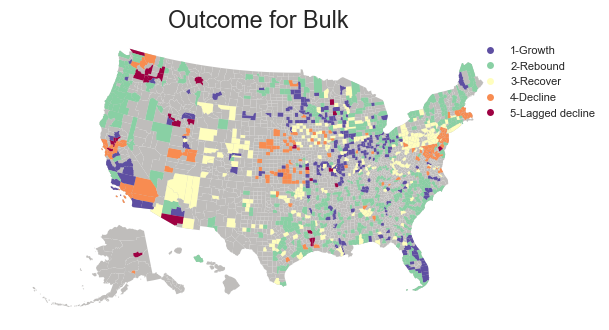

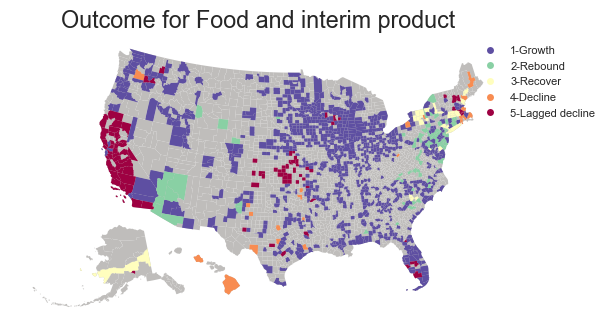

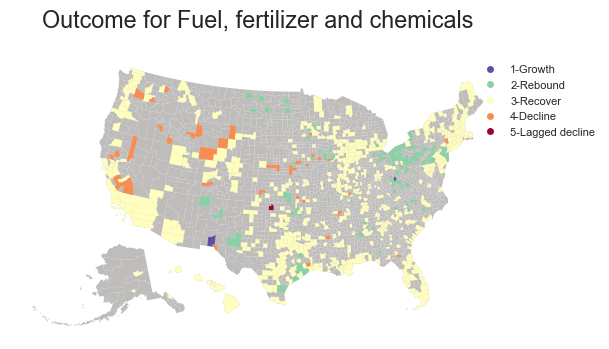

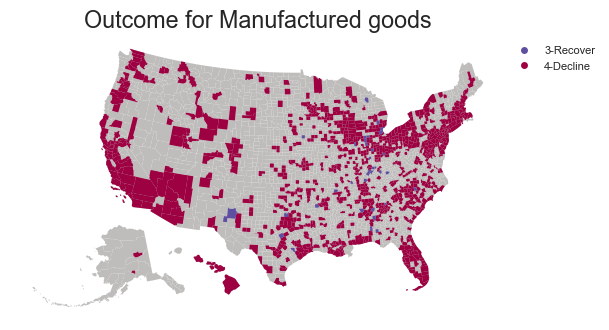

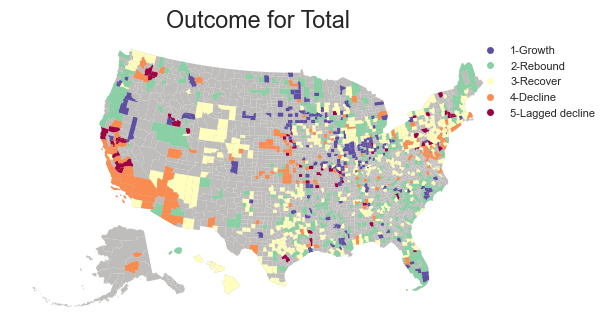

In [71]:
# plot map by mode
outcome_by_sctg_zone = pd.pivot(commodity_outcome_by_sctg, index = 'GEOID', columns='Commodity', values = 'Outcome').reset_index()


outcome_by_sctg_zone.loc[:, 'GEOID'] = outcome_by_sctg_zone.loc[:, 'GEOID'].astype(int).astype(str).str.zfill(5)

us_counties_with_sctg = us_counties.merge(outcome_by_sctg_zone, on = 'GEOID', how = 'inner')


# Create a ListedColormap
custom_cmap = ListedColormap(color_list)
for comm in commodity_outcome_by_sctg.Commodity.unique():
    ax = us_counties.plot(facecolor='#bfbdbb', linewidth = 0.01)
    us_counties_with_to_plot = us_counties_with_sctg.dropna(subset = [comm])
    us_counties_with_to_plot.plot(
            figsize=(6, 4.5),
            ax = ax,
            column=comm, 
            legend=True,
            cmap = 'Spectral_r',
#             color=us_counties_with_to_plot['color'],
            linewidth=0.01, categorical = True,
            legend_kwds={'bbox_to_anchor': (1.2, 1), 'markerscale': 0.5, 'fontsize':8},
            edgecolor='none')
#     leg = ax.get_legend()
#     leg.set_bbox_to_anchor((1.15, 1))  # (x, y) -- adjust x for distance from plot
#     for text in leg.get_texts():
#         text.set_fontsize(8)  # Smaller label font
    ax.grid(False)
    ax.axis('off')
    plt.title(f'Outcome for {comm}')
    filename = os.path.join(plot_dir, 'outcome_for_sctg_' + mode + '.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    # break